##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for experts

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/advanced"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

Import TensorFlow into your program:

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.18.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Use `tf.data` to batch and shuffle the dataset:

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [5]:
for batch in train_ds.take(1):
  print(batch[0].shape)
  print(batch[1].shape)
  break

(32, 28, 28, 1)
(32,)


Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [14]:
class MyModel(Model):
  def __init__(self):
    super().__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.conv2 = Conv2D(64, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(128, activation='relu')
    self.d3 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.d2(x)
    return self.d3(x)

# Create an instance of the model
model = MyModel()

Choose an optimizer and loss function for training:

In [15]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [16]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Use `tf.GradientTape` to train the model:

In [17]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

Test the model:

In [18]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [21]:
EPOCHS = 10

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_state()
  train_accuracy.reset_state()
  test_loss.reset_state()
  test_accuracy.reset_state()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result():0.2f}, '
    f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
    f'Test Loss: {test_loss.result():0.2f}, '
    f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
  )

Epoch 1, Loss: 0.00, Accuracy: 99.96, Test Loss: 0.14, Test Accuracy: 98.69
Epoch 2, Loss: 0.01, Accuracy: 99.88, Test Loss: 0.11, Test Accuracy: 98.85
Epoch 3, Loss: 0.00, Accuracy: 99.93, Test Loss: 0.11, Test Accuracy: 98.91
Epoch 4, Loss: 0.00, Accuracy: 99.91, Test Loss: 0.13, Test Accuracy: 98.84
Epoch 5, Loss: 0.00, Accuracy: 99.93, Test Loss: 0.10, Test Accuracy: 98.97
Epoch 6, Loss: 0.00, Accuracy: 99.93, Test Loss: 0.09, Test Accuracy: 98.95
Epoch 7, Loss: 0.00, Accuracy: 99.92, Test Loss: 0.11, Test Accuracy: 98.93
Epoch 8, Loss: 0.00, Accuracy: 99.93, Test Loss: 0.11, Test Accuracy: 98.96
Epoch 9, Loss: 0.00, Accuracy: 99.96, Test Loss: 0.11, Test Accuracy: 98.83
Epoch 10, Loss: 0.00, Accuracy: 99.93, Test Loss: 0.14, Test Accuracy: 98.79


The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).

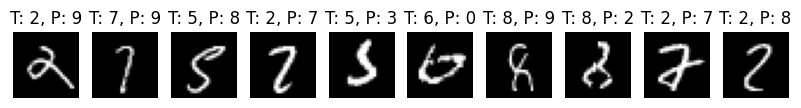

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already trained the 'model' and have 'test_ds' available

# Function to display misclassified examples
def display_errors(model, test_ds, num_errors=10):
  """Displays a few misclassified examples from the test dataset.

  Args:
    model: The trained TensorFlow model.
    test_ds: The TensorFlow Dataset containing test data.
    num_errors: The number of errors to display.
  """

  errors = []
  count = 0

  for images, labels in test_ds:
    predictions = model(images, training=False)
    predicted_labels = np.argmax(predictions, axis=1)
    misclassified_indices = np.where(predicted_labels != labels.numpy())[0]

    for index in misclassified_indices:
      errors.append((images[index], labels[index], predicted_labels[index]))
      count += 1
      if count >= num_errors:
        break
    if count >= num_errors:
      break

  # Display the errors
  plt.figure(figsize=(10, 5))
  for i, (image, true_label, predicted_label) in enumerate(errors):
    plt.subplot(1, num_errors, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap='gray')  # Display as grayscale
    plt.title(f"T: {true_label}, P: {predicted_label}")
    plt.axis('off')
  plt.show()

# Call the function to display errors
display_errors(model, test_ds)